In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import matplotlib.pyplot as plt

In [2]:
train_url = 'NSL_KDD_Train.csv'
test_url = 'NSL_KDD_Test.csv'

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


df = pd.read_csv(train_url,header=None, names = col_names)

df_test = pd.read_csv(test_url, header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [4]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Step 1: Data preprocessing:

One-Hot-Encoding is used to convert all categorical properties to binary properties. One-Hot-Endcoding requirement, the input to this transformer must be an integer matrix expressing values ​​taken with categorical (discrete) properties. The output will be a sparse matrix in which each column corresponds to a possible value. It is assumed that the input properties have values ​​in the range [0, n_values]. Therefore, to convert each category to a number, properties must first be converted with LabelEncoder.

In [6]:
#training set
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [7]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


# LabelEncoder

Insert categorical features into a 2D numpy array

In [8]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [9]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

Transform categorical features into numbers using LabelEncoder()

In [10]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)

print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())

# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


One-Hot-Encoding

In [11]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)


# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Missing columns in test set are added

In [12]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_aol',
 'service_http_2784',
 'service_harvest',
 'service_red_i',
 'service_urh_i',
 'service_http_8001']

In [13]:
for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


** New numeric columns are added to the main dataframe**

In [14]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


The dataset was divided into separate datasets for each attack category. Attack tags have been renamed for each. 
0 = Normal, 1 = DoS, 2 = Probe, 3 = R2L, 4 = U2R.

In [15]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [16]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

#train
DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];

print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)

Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


# Step 2: Feature Scaling

In [17]:
# Split dataframes into X & Y

#train set
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label

X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label

X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label

X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label

X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label

X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label

X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

C:\Users\Aamina Akbar\AppData\Local\Temp\ipykernel_4152\878774939.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_DoS = DoS_df.drop('label',1)
C:\Users\Aamina Akbar\AppData\Local\Temp\ipykernel_4152\878774939.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_Probe = Probe_df.drop('label',1)
C:\Users\Aamina Akbar\AppData\Local\Temp\ipykernel_4152\878774939.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_R2L = R2L_df.drop('label',1)
C:\Users\Aamina Akbar\AppData\Local\Temp\ipykernel_4152\878774939.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_U2R = U2R_df.drop('label',1)
C:\Users\Aamina Akbar\AppData\Local\Temp\ipyke

In [18]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [19]:
from sklearn import preprocessing

#train data
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 

scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe)

scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L)

scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 

scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 

scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 

scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

# Random Forest

In [20]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10,n_jobs=2)
#rfe = RFE(estimator=clf, n_features_to_select=13, step=1)

In [21]:
# train data
clf_DoS=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_Probe=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_R2L=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_U2R=RandomForestClassifier(n_estimators=10,n_jobs=2)

#test data
clf_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_U2R.fit(X_U2R, Y_U2R.astype(int))

RandomForestClassifier(n_estimators=10, n_jobs=2)

# Prediction & Evaluation (validation):

Using all Features for each category

Confusion Matrices

# dos

In [22]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9203,508
1,5965,1495


# Probe

In [23]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9539,172
2,1457,964


# R2L

In [24]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
3,2885


# U2R

In [25]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


# Cross Validation: Accuracy, Precision, Recall, F-measure

DoS

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99761 (+/- 0.00191)
Precision: 0.99946 (+/- 0.00132)
Recall: 0.99678 (+/- 0.00383)
F-measure: 0.99765 (+/- 0.00193)


<BarContainer object of 4 artists>

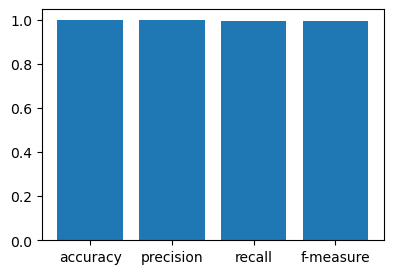

In [27]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99814, 0.99879, 0.99678, 0.99738]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

Probe

In [28]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99711 (+/- 0.00236)
Precision: 0.99607 (+/- 0.00687)
Recall: 0.99360 (+/- 0.00520)
F-measure: 0.99456 (+/- 0.00362)


<BarContainer object of 4 artists>

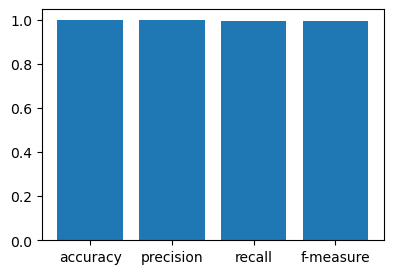

In [29]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99679, 0.99597, 0.99282, 0.99534]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

U2R

In [30]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99714 (+/- 0.00271)
Precision: 0.96959 (+/- 0.09358)
Recall: 0.84379 (+/- 0.13216)
F-measure: 0.90621 (+/- 0.09189)


<BarContainer object of 4 artists>

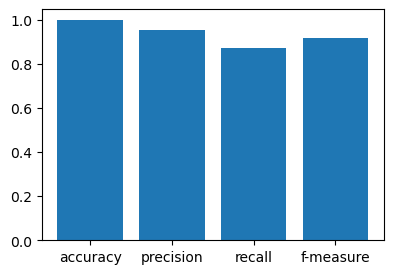

In [31]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99785, 0.95152, 0.87241, 0.91915]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

R2L

In [32]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.98039 (+/- 0.00755)
Precision: 0.97478 (+/- 0.01003)
Recall: 0.96931 (+/- 0.01199)
F-measure: 0.97200 (+/- 0.01143)


<BarContainer object of 4 artists>

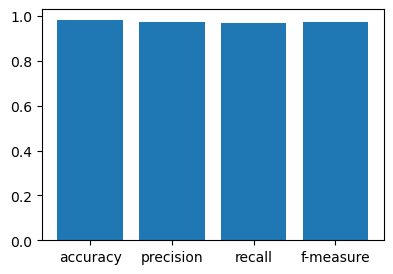

In [33]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.98023, 0.97462, 0.97004, 0.97228]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

# KNeighbors

In [34]:
from sklearn.neighbors import KNeighborsClassifier

clf_KNN_DoS=KNeighborsClassifier()
clf_KNN_Probe=KNeighborsClassifier()
clf_KNN_R2L=KNeighborsClassifier()
clf_KNN_U2R=KNeighborsClassifier()

clf_KNN_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_KNN_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_KNN_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_KNN_U2R.fit(X_U2R, Y_U2R.astype(int))

KNeighborsClassifier()

DoS

In [35]:
Y_DoS_pred=clf_KNN_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9422,289
1,1573,5887


Probe

In [36]:
Y_Probe_pred=clf_KNN_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9437,274
2,1272,1149


R2L

In [37]:
Y_R2L_pred=clf_KNN_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9706,5
3,2883,2


U2R

In [38]:
Y_U2R_pred=clf_KNN_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9711,0
4,65,2


# Cross Validation: Accuracy, Precision, Recall, F-measure

DoS

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99715 (+/- 0.00278)
Precision: 0.99678 (+/- 0.00383)
Recall: 0.99665 (+/- 0.00344)
F-measure: 0.99672 (+/- 0.00320)


<BarContainer object of 4 artists>

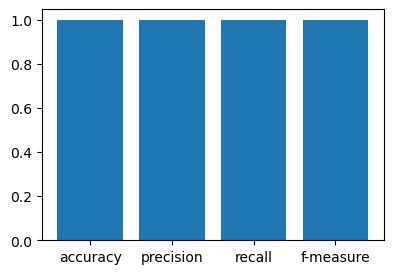

In [40]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99715, 0.99678, 0.99665, 0.99672]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

Probe

In [41]:
accuracy = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99077 (+/- 0.00403)
Precision: 0.98606 (+/- 0.00675)
Recall: 0.98508 (+/- 0.01137)
F-measure: 0.98553 (+/- 0.00645)


<BarContainer object of 4 artists>

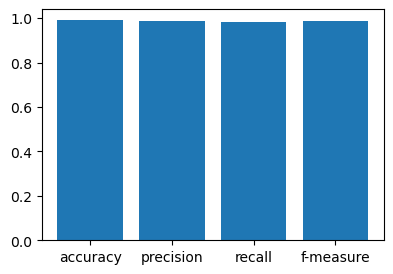

In [42]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99077, 0.98606, 0.98508, 0.98553]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

R2L

In [43]:
accuracy = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.96721 (+/- 0.00707)
Precision: 0.95287 (+/- 0.01194)
Recall: 0.95462 (+/- 0.01345)
F-measure: 0.95367 (+/- 0.01003)


<BarContainer object of 4 artists>

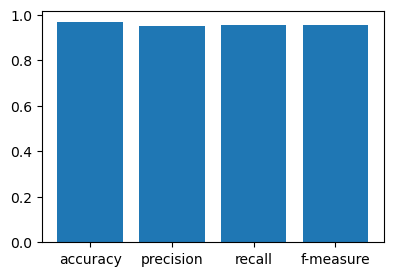

In [44]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.96721, 0.95287, 0.95462, 0.95367]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

U2R

In [45]:
accuracy = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_KNN_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99703 (+/- 0.00281)
Precision: 0.93143 (+/- 0.14679)
Recall: 0.85073 (+/- 0.17639)
F-measure: 0.87831 (+/- 0.11390)


<BarContainer object of 4 artists>

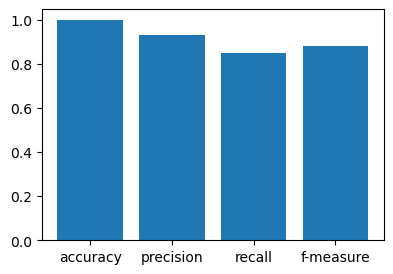

In [46]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99703, 0.93143, 0.85073, 0.87831]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

# SVM

In [47]:
from sklearn.svm import SVC

clf_SVM_DoS=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_Probe=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_R2L=SVC(kernel='linear', C=1.0, random_state=0)
clf_SVM_U2R=SVC(kernel='linear', C=1.0, random_state=0)

clf_SVM_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_SVM_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_SVM_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_SVM_U2R.fit(X_U2R, Y_U2R.astype(int))

SVC(kernel='linear', random_state=0)

DoS

In [48]:
Y_DoS_pred=clf_SVM_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9455,256
1,1359,6101


Probe

In [49]:
Y_Probe_pred=clf_SVM_Probe.predict(X_Probe_test)
# Create confusion matrix

pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9576,135
2,1285,1136


R2L

In [50]:
Y_R2L_pred=clf_SVM_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9639,72
3,2737,148


U2R

In [51]:
Y_U2R_pred=clf_SVM_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9710,1
4,67,0


# Cross Validation: Accuracy, Precision, Recall, F-measure

DoS

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99371 (+/- 0.00375)
Precision: 0.99107 (+/- 0.00785)
Recall: 0.99450 (+/- 0.00388)
F-measure: 0.99278 (+/- 0.00428)


<BarContainer object of 4 artists>

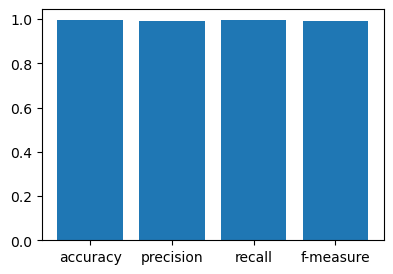

In [53]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99371, 0.99107, 0.99450, 0.99278]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

Probe

In [54]:
accuracy = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.98450 (+/- 0.00526)
Precision: 0.96907 (+/- 0.01031)
Recall: 0.98365 (+/- 0.00686)
F-measure: 0.97613 (+/- 0.00800)


<BarContainer object of 4 artists>

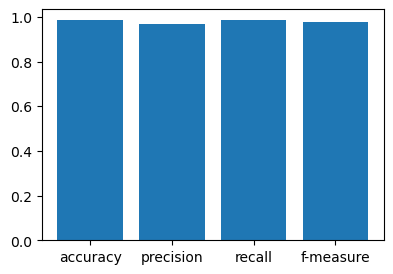

In [55]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.98450, 0.96907, 0.98365, 0.97613]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

R2L

In [56]:
accuracy = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.96793 (+/- 0.00738)
Precision: 0.94854 (+/- 0.00994)
Recall: 0.96264 (+/- 0.01388)
F-measure: 0.95529 (+/- 0.01048)


<BarContainer object of 4 artists>

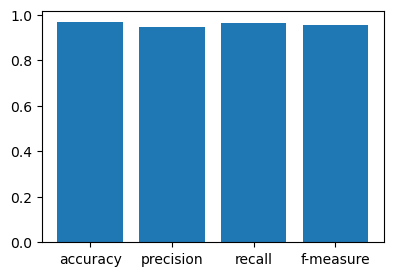

In [57]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.96793, 0.94854, 0.96264, 0.95529]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

U2R

In [58]:
accuracy = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_SVM_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99632 (+/- 0.00390)
Precision: 0.91056 (+/- 0.17934)
Recall: 0.82909 (+/- 0.21833)
F-measure: 0.84869 (+/- 0.16029)


<BarContainer object of 4 artists>

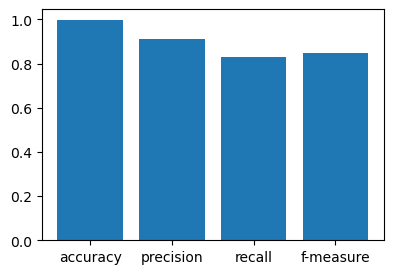

In [59]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99632, 0.91056, 0.82909, 0.84869]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

# Ensemble Learning

In [60]:
from sklearn.ensemble import VotingClassifier

clf_voting_DoS = VotingClassifier(estimators=[('rf', clf_DoS), ('knn', clf_KNN_DoS), ('svm', clf_SVM_DoS)], voting='hard')
clf_voting_Probe = VotingClassifier(estimators=[('rf', clf_Probe), ('knn', clf_KNN_Probe), ('svm', clf_SVM_Probe)], voting='hard')
clf_voting_R2L = VotingClassifier(estimators=[('rf', clf_R2L), ('knn', clf_KNN_R2L), ('svm', clf_SVM_R2L)], voting='hard')
clf_voting_U2R = VotingClassifier(estimators=[('rf', clf_U2R), ('knn', clf_KNN_U2R), ('svm', clf_SVM_U2R)], voting='hard')

clf_voting_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_voting_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_voting_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_voting_U2R.fit(X_U2R, Y_U2R.astype(int))

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     n_jobs=2)),
                             ('knn', KNeighborsClassifier()),
                             ('svm', SVC(kernel='linear', random_state=0))])

DoS

In [61]:
Y_DoS_pred=clf_voting_DoS.predict(X_DoS_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9607,104
1,1929,5531


Probe

In [62]:
Y_Probe_pred=clf_voting_Probe.predict(X_Probe_test)

# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9529,182
2,1108,1313


R2L

In [63]:
Y_R2L_pred=clf_voting_R2L.predict(X_R2L_test)

# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9711,0
3,2884,1


U2R

In [64]:
Y_U2R_pred=clf_voting_U2R.predict(X_U2R_test)

# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
4,67


# Cross Validation: Accuracy, Precision, Recall, F-measure

DoS

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_voting_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_voting_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_voting_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_voting_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99773 (+/- 0.00236)
Precision: 0.99826 (+/- 0.00319)
Recall: 0.99678 (+/- 0.00364)
F-measure: 0.99785 (+/- 0.00239)


<BarContainer object of 4 artists>

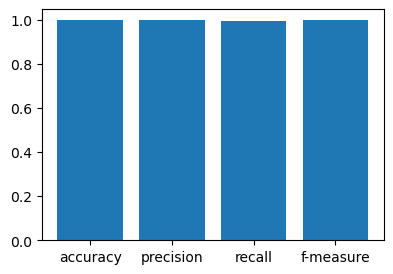

In [66]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99819, 0.99839, 0.99678, 0.99772]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

Probe

In [67]:
accuracy = cross_val_score(clf_voting_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_voting_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_voting_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_voting_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-mesaure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99242 (+/- 0.00374)
Precision: 0.98745 (+/- 0.00694)
Recall: 0.98994 (+/- 0.00798)
F-mesaure: 0.98841 (+/- 0.00566)


<BarContainer object of 4 artists>

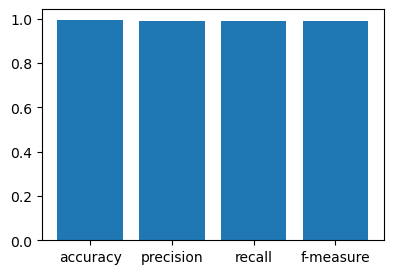

In [68]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99275, 0.98749, 0.98958, 0.98854]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

R2L

In [69]:
accuracy = cross_val_score(clf_voting_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_voting_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_voting_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_voting_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97229 (+/- 0.00519)
Precision: 0.95847 (+/- 0.00807)
Recall: 0.96312 (+/- 0.01327)
F-measure: 0.95994 (+/- 0.00641)


<BarContainer object of 4 artists>

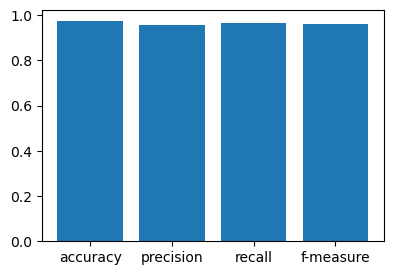

In [70]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.97269, 0.95796, 0.96352, 0.96010]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)

U2R

In [71]:
accuracy = cross_val_score(clf_voting_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_voting_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_voting_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_voting_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99744 (+/- 0.00333)
Precision: 0.93823 (+/- 0.13824)
Recall: 0.87345 (+/- 0.16048)
F-measure: 0.90005 (+/- 0.10432)


<BarContainer object of 4 artists>

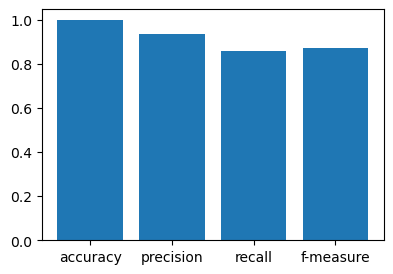

In [72]:
names = ['accuracy', 'precision', 'recall', 'f-measure']
values = [0.99765, 0.93657, 0.85792, 0.87347]
f = plt.figure(figsize =(15, 3), num = 10)
plt.subplot(131)
plt.bar(names, values)